<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-deep-learning/blob/main/4.%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchsummary import summary
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla K80


# Generate data

In [19]:
# Class 0
lstX=[]
lstY=[]
for i in range(1000):
  x1 = np.random.normal(0.5, 0.3) # mean and standard deviation
  x2 = np.random.normal(0, 0.3)
  x3 = np.random.normal(0.8, 0.3)
  x4 = np.random.normal(0.3, 0.8)
  x5 = np.random.normal(0.6, 0.5)
  x6 = np.random.normal(0.5, 0.3)
  x7 = np.random.normal(0, 0.6)
  lstX.append([x1, x2, x3, x4, x5, x6, x7])
  lstY.append(0)

In [20]:
# Class 1
for i in range(1200):
  x1 = np.random.normal(0.1, 0.6) 
  x2 = np.random.normal(0.5, 0.3)
  x3 = np.random.normal(0.6, 0.4)
  x4 = np.random.normal(0.1, 0.2)
  x5 = np.random.normal(0.4, 0.3)
  x6 = np.random.normal(0.35, 0.6)
  x7 = np.random.normal(-0.1, 0.3)
  lstX.append([x1, x2, x3, x4, x5, x6, x7])
  lstY.append(1)

In [21]:
#convert data to numpy array
numpyX = np.array(lstX)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(2200, 7) (2200,)


# Define NN

In [22]:
MyNet = nn.Sequential(
    nn.Linear(7, 56),
    nn.ReLU(),
    nn.Linear(56, 56),
    nn.ReLU(),
    nn.Linear(56, 2),
)
MyNet.to(device)

Sequential(
  (0): Linear(in_features=7, out_features=56, bias=True)
  (1): ReLU()
  (2): Linear(in_features=56, out_features=56, bias=True)
  (3): ReLU()
  (4): Linear(in_features=56, out_features=2, bias=True)
)

In [23]:
BATCH_SIZE = 500
summary(MyNet, input_size=(BATCH_SIZE, 7))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 500, 56]             448
              ReLU-2              [-1, 500, 56]               0
            Linear-3              [-1, 500, 56]           3,192
              ReLU-4              [-1, 500, 56]               0
            Linear-5               [-1, 500, 2]             114
Total params: 3,754
Trainable params: 3,754
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.86
Params size (MB): 0.01
Estimated Total Size (MB): 0.89
----------------------------------------------------------------


# Run training-test N times

In [24]:
train_lossLst = []
test_accuracyLst = []
for i in range(1, 6):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.LongTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,  
      batch_size=BATCH_SIZE,      
      shuffle=True,       
      num_workers=0,   
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

  # train NN 
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 200):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_lossLst.append(epoch_lossLst) 

  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.LongTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)

  #calculate accuracy
  correct = 0
  tensorY_hat = torch.softmax(tensorY_hat, 1)
  MaxIdxOfEachRow = torch.max(tensorY_hat, 1)[1]
  for i in range(tensorY.shape[0]):
    if (int(MaxIdxOfEachRow[i]) == int(tensorY[i])):
      correct += 1
  accuracy = correct/tensorY.shape[0]
  print("%.2f" % accuracy)
  test_accuracyLst.append(accuracy)


Train-test  1 epoch: 100,0.95

Train-test  2 epoch: 100,0.95

Train-test  3 epoch: 100,0.94

Train-test  4 epoch: 100,0.95

Train-test  5 epoch: 100,0.94


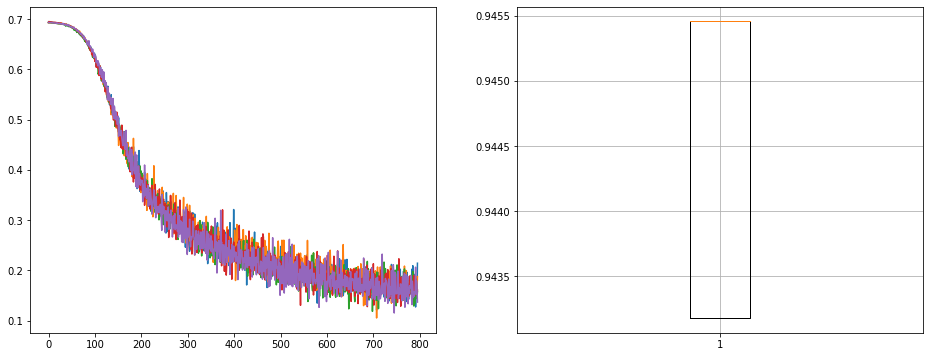

In [25]:
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2) 
plt.boxplot(test_accuracyLst)
plt.grid()
plt.show()